# **EDA Credit Card Balance**

## **Table of contents**

* [Our goals](#Our-goals)
* [About the data](#About-the-data)
* [Generalities](#Generalities)
* [Missing values](#Missing-values)
* [Raw features description](#Raw-features-description)
* [Features creation](#Features-creation)
* [Summary](#Summary)

In [1]:
import sys
import os
from pathlib import Path

project_root = str(Path(os.getcwd()).parent)
if project_root not in sys.path:
    sys.path.append(project_root)

from utilities import (
    stat_utilities,
    plot_utilities
)

from utilities.stat_utilities import get_missing_values
from utilities.plot_utilities import (
    to_percent, 
    plot_triangle_corr_matrix, 
    Rstyle_spines
)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [2]:
data_dir = "../sample_data/"
sample_credit = pd.read_parquet(data_dir + "sample_credit_card_balance.parquet")

## **Our goals**

<div style="background-color: #f8d7dA; padding: 10px; border-radius: 5px;">
    
In this notebook we aim at:
* **Exploring the Installment Dataset:** Perform EDA to identify potential anomalies.
* **Creating New Features:** Apply two-stage aggregation on SK_ID_PREV and SK_ID_CURR.
* **Building Functions:** Create functions to compute new features and join them with the main dataframe.
* **Visualizing Relationships:** Visualize how the features relate to each other.
</div>

## **About the data**

## **Generalities**

In [3]:
sample_credit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 655258 entries, 19 to 3840308
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   SK_ID_PREV                  655258 non-null  int32   
 1   SK_ID_CURR                  655258 non-null  int32   
 2   MONTHS_BALANCE              655258 non-null  int8    
 3   AMT_BALANCE                 655258 non-null  float64 
 4   AMT_CREDIT_LIMIT_ACTUAL     655258 non-null  int32   
 5   AMT_DRAWINGS_ATM_CURRENT    531917 non-null  float64 
 6   AMT_DRAWINGS_CURRENT        655258 non-null  float64 
 7   AMT_DRAWINGS_OTHER_CURRENT  531917 non-null  float64 
 8   AMT_DRAWINGS_POS_CURRENT    531917 non-null  float64 
 9   AMT_INST_MIN_REGULARITY     601483 non-null  float64 
 10  AMT_PAYMENT_CURRENT         528681 non-null  float64 
 11  AMT_PAYMENT_TOTAL_CURRENT   655258 non-null  float64 
 12  AMT_RECEIVABLE_PRINCIPAL    655258 non-null  float64 
 13  AM

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
Here is a list describing briefly each feature:

* **`MONTHS_BALANCE`:** Month of balance relative to application date (-1 means the freshest balance date)
* **`AMT_BALANCE`:** Balance during the month of previous credit
* **`AMT_CREDIT_LIMIT_ACTUAL`:** Credit card limit during the month of the previous credit
* **`AMT_DRAWINGS_ATM_CURRENT`:** Amount drawing at ATM during the month of the previous credit
* **`AMT_DRAWINGS_CURRENT`:** Amount drawing during the month of the previous credit
* **`AMT_DRAWINGS_OTHER_CURRENT`:** Amount of other drawings during the month of the previous credit
* **`AMT_DRAWINGS_POS_CURRENT`:** Amount drawing or buying goods during the month of the previous credit
* **`AMT_INST_MIN_REGULARITY`:** Minimal installment for this month of the previous credit
* **`AMT_PAYMENT_CURRENT`:** How much did the client pay during the month on the previous credit
* **`AMT_PAYMENT_TOTAL_CURRENT`:** How much did the client pay during the month in total on the previous credit
* **`AMT_RECEIVABLE_PRINCIPAL`:** Amount receivable for principal on the previous credit
* **`AMT_RECEIVABLE`:** Amount receivable on the previous credit
* **`AMT_TOTAL_RECEIVABLE`:** Total amount receivable on the previous credit
* **`CNT_DRAWINGS_ATM_CURRENT`:** Number of drawings at ATM during this month on the previous credit
* **`CNT_DRAWINGS_CURRENT`:** Number of drawings during this month on the previous credit
* **`CNT_DRAWINGS_OTHER_CURRENT`:** Number of other drawings during this month on the previous credit
* **`CNT_DRAWINGS_POS_CURRENT`:** Number of drawings for goods during this month on the previous credit
* **`CNT_INSTALMENT_MATURE_CUM`:** Number of paid installments on the previous credit
* **`SK_DPD`:** DPD (Days past due) during the month on the previous credit
* **`SK_DPD_DEF`:** DPD (Days past due) during the month with tolerance (debts with low loan amounts are ignored) of the previous credit
* **`NAME_CONTRACT_STATUS`:** Contract status (active signed,...) on the previous credit
</div>

## **Missing values**

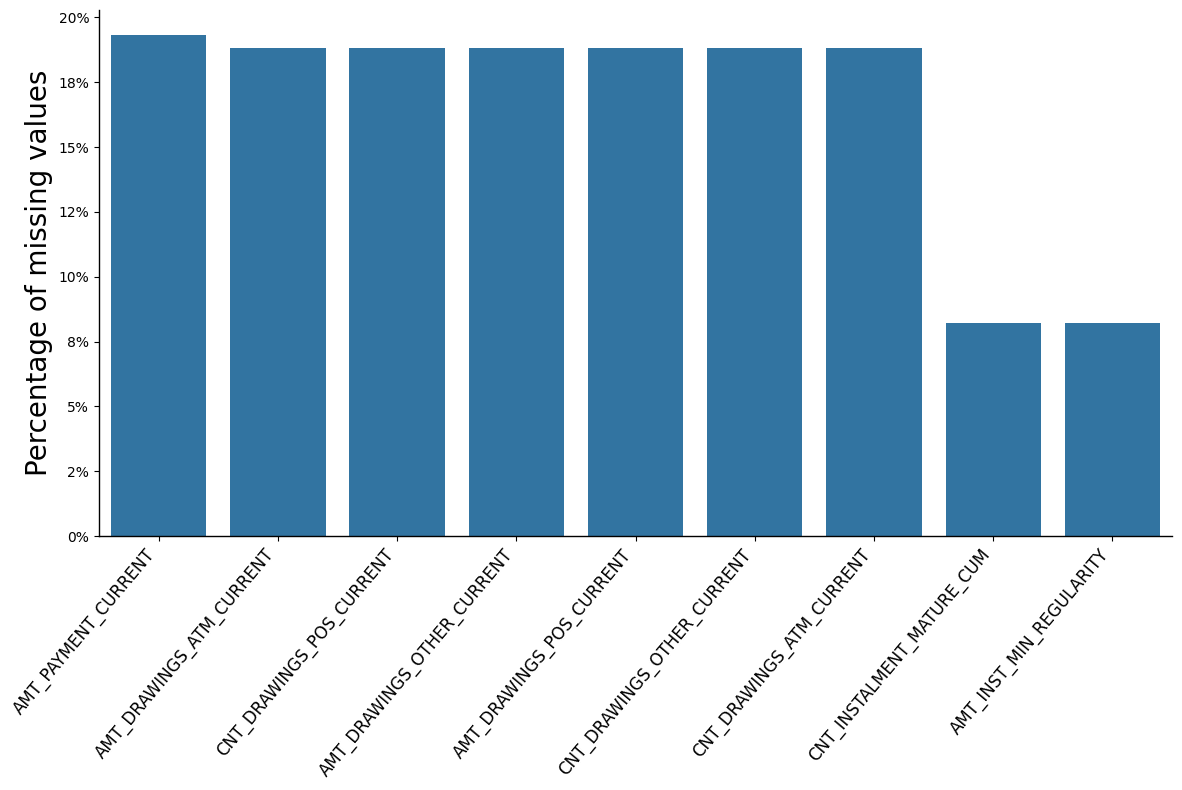

In [4]:
fig, ax = plt.subplots(figsize=(12, 8))
cre_na = get_missing_values(sample_credit)
cre_na = cre_na[cre_na["Count"] > 0]
sns.barplot(cre_na, x=cre_na.index, y="Percent", ax=ax)
Rstyle_spines(ax, lw=1)
ax.set_xticks(range(0, len(cre_na.index)))
ax.set_xticklabels(cre_na.index, rotation=50, ha="right", fontsize=12)
ax.yaxis.set_major_formatter(FuncFormatter(to_percent))
ax.set_xlabel("")
ax.set_ylabel("Percentage of missing values", fontsize=20)
plt.tight_layout()

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
We have some missing values, which are specific to certain types of loans. If the current loan is of a different type, the value is naturally missing. We'll impute these missing values with 0.
</div>

In [5]:
sample_credit.replace(np.nan, 0, inplace=True)

## **Raw features distribution**

In [6]:
cre_cat_cols = list(sample_credit.select_dtypes(include="category").columns.values)
cre_num_cols = [
    col
    for col in sample_credit.select_dtypes(include="number").columns
    if not col.startswith(("SK_ID_PREV", "SK_ID_CURR"))
]

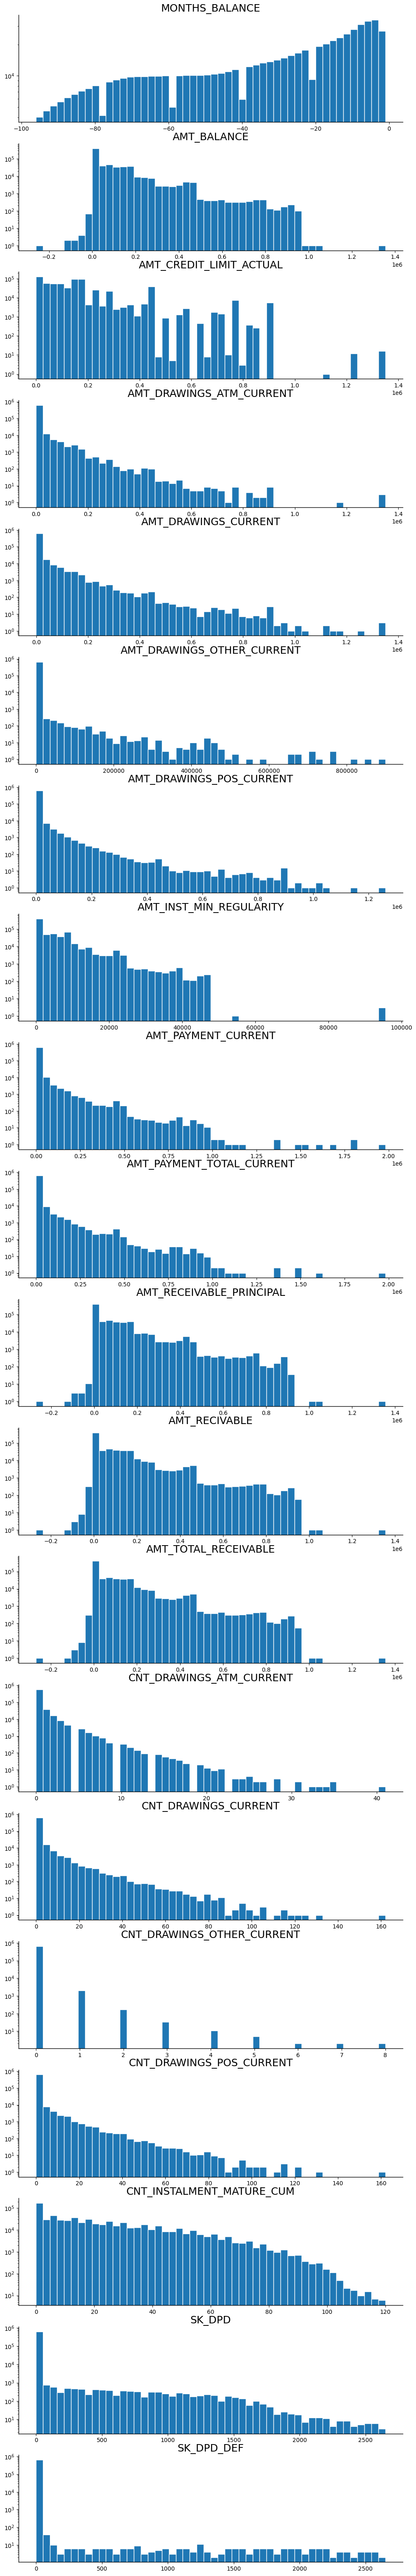

In [7]:
fig, axs = plt.subplots(len(cre_num_cols), 1, figsize=(12, 4 * len(cre_num_cols)))
for i, feature in enumerate(cre_num_cols):
    N, bins, patches = axs[i].hist(
        sample_credit[feature], bins=50, color="C0", edgecolor="w"
    )
    axs[i].set_yscale("log")
    axs[i].set_title(feature, fontsize=18)
    Rstyle_spines(axs[i], lw=1)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
Some values are exceptionally large, making it difficult to understand how such amounts could, for instance, be withdrawn. However, they don't stand out significantly compared to others, making it challenging to conclude that they are errors. While amounts exceeding a million (within one month) seem unrealistic, removing all of them could result in the loss of valid information.
</div>

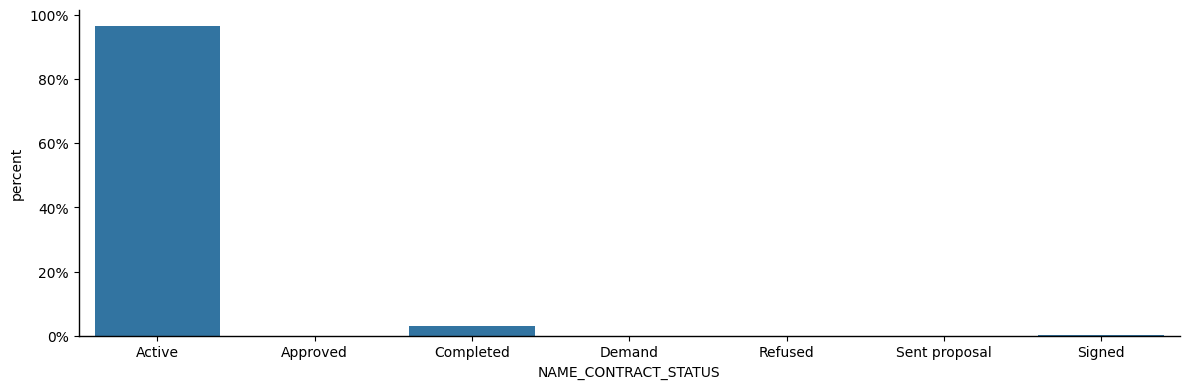

In [8]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.countplot(data=sample_credit, x="NAME_CONTRACT_STATUS", ax=ax, stat="percent")
Rstyle_spines(ax, lw=1)
ax.yaxis.set_major_formatter(FuncFormatter(to_percent))
plt.tight_layout()

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
For each month an account is active, an occurrence will automatically be added to the "Active" status, which explains its predominance. Therefore, we'll focus more on examining the final status of each loan.
</div>

## **Features creation**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
    
To move forward with feature engineering from the Credit Card dataset, we will design a function that will apply two layers of aggregation over `SK_ID_PREV` (individual loans) and `SK_ID_CURR` (loan applicants). We'll try to generate new features that capture meaningful patterns in repayment behavior, which are likely to help our model predict defaults.
Here are the features we plan to create:

* **Features:**
    * **Total Drawing `TOTAL_DRAWING_SUM`:**
        * **Concept:** This will tell us how much did the loan applicant drew from his different account
        * **Aggregation Strategy:**
            * **Step 1 (`SK_ID_PREV`):** Get  the sum (**SUM**) of `TOTAL_DRAWING_SUM` for each loan and this over different time windows: **EVER**, **LAST_YEAR** and **LAST_3_MONTHS**.
            * **Step 2 (`SK_ID_CURR`):** For each applicant, aggregate this information using the mean (**AVG**), the sum (**SUM**) and the maximum (**MAX**)
    * **Amount Balance `AMT_BALANCE`:**
        * **Concept:** This will tell us how much is the loan applicant balance over his different accounts
        * **Aggregation Strategy:**
            * **Step 1 (`SK_ID_PREV`):** Get  the sum (**SUM**) of `AMT_BALANCE` for each loan and this over different time windows: **EVER**, **LAST_YEAR** and **LAST_3_MONTHS**.
            * **Step 2 (`SK_ID_CURR`):** For each applicant, aggregate this information using the mean (**AVG**), the sum (**SUM**) and the maximum (**MAX**)
    * **Total Count Drawing `TOT_CNT_DRAWING`:**
        * **Concept:** This will tell us how much did the loan applicant drew from his different account
        * **Aggregation Strategy:**
            * **Step 1 (`SK_ID_PREV`):** Get  the sum (**SUM**) of `TOT_CNT_DRAWING` for each loan and this over different time windows: **EVER**, **LAST_YEAR** and **LAST_3_MONTHS**.
            * **Step 2 (`SK_ID_CURR`):** For each applicant, aggregate this information using the sum (**SUM**)
    * **Number of days past due `SK_DPD`:**
        * **Concept:** This will tell us if the loan applicant was paying his instalments in time or not, and more important if he has accumulated some unpaid instalments
        * **Aggregation Strategy:**
            * **Step 1 (`SK_ID_PREV`):** Get  the maximum (**MAX**) of `SK_DPD` for each loan and this over different time windows: **EVER**, **LAST_YEAR** and **LAST_3_MONTHS**.
            * **Step 2 (`SK_ID_CURR`):** For each applicant, aggregate this information using the mean (**AVG**)
    * **Number of days past due with tolerance `SK_DPD_DEF`:**
        * **Concept:** This will tell us if the loan applicant was paying his instalments in time or not, and more important if he has accumulated some unpaid instalments and how the Home Credit was adjusting its tolerance towards it.
        * **Aggregation Strategy:**
            * **Step 1 (`SK_ID_PREV`):** Get the maximum (**MAX**) of `SK_DPD_DEF` for each loan and this over different time windows: **EVER**, **LAST_YEAR** and **LAST_3_MONTHS**.
            * **Step 2 (`SK_ID_CURR`):** For each applicant, aggregate this information using the mean (**AVG**)
    * **Ratio of Number of days past due with tolerance vs Number of days past due `SK_DPD_DEF` / `SK_DPD`:**
        * **Concept:** This will tell us how the relation between the number of days past due compared with the number of tolerated days past due
        * **Aggregation Strategy:**
            * **Step 1 (`SK_ID_PREV`):** Get  the maximum (**MAX**) of `SK_DPD_DEF` / `SK_DPD` for each loan and this over different time windows: **EVER**, **LAST_YEAR** and **LAST_3_MONTHS**.
            * **Step 2 (`SK_ID_CURR`):** For each applicant, aggregate this information using the mean (**AVG**)
    * **Status of the loans `NAME_CONTRACT_STATUS`:**
        * **Concept:** This will tell us what are the status of the different Credit card loans of the applicant
        * **Aggregation Strategy:**
            * **Step 1 (`SK_ID_PREV`):** We need to get the status for the last update. To that end we'll first order the datframe using the `MONTHS_BALANCE` feature.
            * **Step 2:** We will one-hot encode the `NAME_CONTRACT_STATUS`.
            * **Step 2 (`SK_ID_CURR`):** For each applicant, aggregate this information using the sum (**SUM**)
    * **Balance Limit Ratio `BALANCE_LIMIT_RATIO`:**
        * **Concept:** This will tell us how is the ratio between the balance and limit for a loan applicant's accounts
        * **Aggregation Strategy:**
            * **Step 1 (`SK_ID_PREV`):** We will get the mean (**AVG**) for the `BALANCE_LIMIT_RATIO` and this over different time windows: **EVER**, **LAST_YEAR** and **LAST_3_MONTHS**.
            * **Step 2 (`SK_ID_CURR`):** For each applicant, aggregate this information using the mean (**AVG**)
    * **Total Payment `AMT_PAYMENT_TOTAL_CURRENT`:**
        * **Concept:** This will tell us how is the ratio between the balance and limit for a loan applicant's accounts
        * **Aggregation Strategy:**
            * **Step 1 (`SK_ID_PREV`):** We will get the sum (**SUM**) for the `AMT_PAYMENT_TOTAL_CURRENT` and this over different time windows: **EVER**, **LAST_YEAR** and **LAST_3_MONTHS**.
            * **Step 2 (`SK_ID_CURR`):** For each applicant, aggregate this information using the mean (**AVG**) and the (**SUM**)
    * **Total Receivable `AMT_TOTAL_RECIVABLE`:**
        * **Concept:** This will tell us how is the ratio between the balance and limit for a loan applicant's accounts
        * **Aggregation Strategy:**
            * **Step 1 (`SK_ID_PREV`):** We will get the sum (**SUM**) for the `AMT_TOTAL_RECIVABLE` and this over different time windows: **EVER**, **LAST_YEAR** and **LAST_3_MONTHS**.
            * **Step 2 (`SK_ID_CURR`):** For each applicant, aggregate this information using the mean (**AVG**) and the (**SUM**)
    * **Receivable Payment Ratio `PAYMENT_RECEIVABLE_RATIO`:**
        * **Concept:** This will tell us how is the ratio between the payment and the receivable for a loan applicant's accounts
        * **Aggregation Strategy:**
            * **Step 1 (`SK_ID_PREV`):** We will get the mean (**AVG**) for the `RECEIVABLE_PAYMENT_RATIO` and this over different time windows: **EVER**, **LAST_YEAR** and **LAST_3_MONTHS**.
            * **Step 2 (`SK_ID_CURR`):** For each applicant, aggregate this information using the mean (**AVG**)
    * **Amount of Receivable Interest (`AMT_INTEREST_RECEIVABLE`):**
        * **Concept:** This will tell us how are the receivable interests for a loan applicant's accounts
        * **Aggregation Strategy:**
            * **Step 1 (`SK_ID_PREV`):** We will get the mean (**AVG**) for the `AMT_INTEREST_RECEIVABLE` and this over different time windows: **EVER**, **LAST_YEAR** and **LAST_3_MONTHS**.
            * **Step 2 (`SK_ID_CURR`):** For each applicant, aggregate this information using the mean (**AVG**)

All this should take place within a function that will, in order, do:
* **Aggregation:** Perform first (`SK_ID_PREV`) and second (`SK_ID_CURR`) aggregations.
* **Output:** The function will return a dataframe with the new features, ready to be joined with the main datframe.

This feature engineering step will create new variables that capture deeper insights into loan repayment behavior and loan applicant's expenditures. These features are expected to improve the classifier’s performance by adding nuanced information about the financial habits of loan applicants. The function must be adaptable for integration into a full preprocessing pipeline within scikit-learn.
</div>

In [9]:
def compute_first_agg_credit_card(df_cre: pd.DataFrame) -> pd.DataFrame:
    # We will now proceed to the first aggregation, this one will take place over SK_ID_PREV
    # We first compute the ratio

    df_cre["TOTAL_DRAWING_SUM"] = (
        df_cre["AMT_DRAWINGS_ATM_CURRENT"]
        + df_cre["AMT_DRAWINGS_CURRENT"]
        + df_cre["AMT_DRAWINGS_OTHER_CURRENT"]
        + df_cre["AMT_DRAWINGS_POS_CURRENT"]
    )
    df_cre["BALANCE_LIMIT_RATIO"] = df_cre["AMT_BALANCE"] / (
        df_cre["AMT_CREDIT_LIMIT_ACTUAL"] + 0.0001
    )
    df_cre["TOT_CNT_DRAWING"] = (
        df_cre["CNT_DRAWINGS_ATM_CURRENT"]
        + df_cre["CNT_DRAWINGS_CURRENT"]
        + df_cre["CNT_DRAWINGS_OTHER_CURRENT"]
        + df_cre["CNT_DRAWINGS_POS_CURRENT"]
        + df_cre["CNT_INSTALMENT_MATURE_CUM"]
    )
    df_cre["RATIO_DPD_DEF_DPD"] = df_cre["SK_DPD_DEF"] / (df_cre["SK_DPD"] + 0.0001)
    df_cre["AMT_INTEREST_RECEIVABLE"] = (
        df_cre["AMT_TOTAL_RECEIVABLE"] - df_cre["AMT_RECEIVABLE_PRINCIPAL"]
    )
    df_cre["PAYMENT_RECEIVABLE_RATIO"] = df_cre["AMT_TOTAL_RECEIVABLE"] / (
        df_cre["AMT_PAYMENT_TOTAL_CURRENT"] + 0.0001
    )

    # We then order the dataset using MONTHS_BALANCE
    df_cre.sort_values(by="MONTHS_BALANCE", ascending=False, inplace=True)

    # We compute LAST_STATUS_POS in the most efficient way (first() much slower)
    last_status_cre = (
        df_cre.groupby(["SK_ID_PREV", "SK_ID_CURR"])["NAME_CONTRACT_STATUS"]
        .nth(0)
        .rename("LAST_STATUS_CRE")
    )

    last_status_cre = (
        pd.concat(
            [
                df_cre.loc[last_status_cre.index][["SK_ID_PREV", "SK_ID_CURR"]],
                last_status_cre,
            ],
            axis=1,
        )
        .sort_values(by=["SK_ID_PREV", "SK_ID_CURR"])
        .set_index(["SK_ID_PREV", "SK_ID_CURR"])
    )

    # Now we can proceed with the temporal ones
    time_windows = [
        ("EVER", df_cre),
        ("LAST_YEAR", df_cre[df_cre["MONTHS_BALANCE"].between(-12, -1)]),
        ("LAST_3_MONTHS", df_cre[df_cre["MONTHS_BALANCE"] > -3]),
    ]
    diff_features = []
    all_window_columns = []
    for window_name, window_df in time_windows:
        agg_dict_diff = {
            "TOTAL_DRAWING_SUM": ["sum"],
            "AMT_BALANCE": ["sum"],
            "TOT_CNT_DRAWING": ["sum"],
            "SK_DPD": ["max"],
            "SK_DPD_DEF": ["max"],
            "RATIO_DPD_DEF_DPD": ["max"],
            "BALANCE_LIMIT_RATIO": ["mean"],
            "AMT_PAYMENT_TOTAL_CURRENT": ["sum"],
            "AMT_TOTAL_RECEIVABLE": ["sum"],
            "PAYMENT_RECEIVABLE_RATIO": ["mean"],
            "AMT_INTEREST_RECEIVABLE": ["mean"],
        }
        window_features = window_df.groupby(["SK_ID_PREV", "SK_ID_CURR"]).agg(
            agg_dict_diff
        )
        window_features.columns = [
            f"{col[0]}_{window_name.upper()}_{col[1].upper()}"
            for col in window_features.columns.values
        ]
        diff_features.append(window_features)
        all_window_columns += list(window_features.columns.values)

    # We can combine all the features, reset the index, fill the missing values for the temporal features by 0 and drop the SK_ID_PREV
    first_agg_features = (
        last_status_cre.join(diff_features).reset_index().drop("SK_ID_PREV", axis=1)
    )
    first_agg_features[all_window_columns] = first_agg_features[
        all_window_columns
    ].fillna(0)

    return first_agg_features

In [10]:
def compute_second_agg_credit_card(first_agg_features: pd.DataFrame) -> pd.DataFrame:
    dum_status = pd.get_dummies(
        first_agg_features["LAST_STATUS_CRE"], dtype=np.int8, prefix="LAST_STATUS_CRE"
    )

    first_agg_features = pd.concat([dum_status, first_agg_features], axis=1)
    first_agg_features.drop("LAST_STATUS_CRE", axis=1, inplace=True)

    # Get the columns for different features
    status_columns = [
        col for col in first_agg_features.columns if col.startswith("LAST_STATUS")
    ]
    temporal_columns = [
        col
        for col in first_agg_features.columns
        if any(p in col for p in ["EVER", "LAST_YEAR", "LAST_3_MONTHS"])
    ]

    # Create the aggregation dictionaries
    agg_dict = {col: "sum" for col in status_columns}
    agg_temp = {col: ["mean"] for col in temporal_columns}
    agg_dict.update(agg_temp)

    # Perform the second aggregation
    second_agg_features = first_agg_features.groupby("SK_ID_CURR").agg(agg_dict)
    second_agg_features.columns = [
        "CRE_BAL_" + "_".join(col).upper() for col in second_agg_features.columns.values
    ]

    return second_agg_features.reset_index()

In [11]:
def compute_features_credit_card(df_cre: pd.DataFrame) -> pd.DataFrame:
    df_cre_ = df_cre.copy()

    # Compute the first agg features (over SK_ID_PREV)
    first_agg = compute_first_agg_credit_card(df_cre_)

    # Compute the second agg features (over SK_ID_CURR)
    second_agg = compute_second_agg_credit_card(first_agg)

    # Reset the index to be SK_ID_CURR
    second_agg.set_index("SK_ID_CURR", inplace=True)

    return second_agg

In [12]:
cre_features = compute_features_credit_card(sample_credit)
cre_features.head(5)

,CRE_BAL_LAST_STATUS_CRE_ACTIVE_SUM,CRE_BAL_LAST_STATUS_CRE_APPROVED_SUM,CRE_BAL_LAST_STATUS_CRE_COMPLETED_SUM,CRE_BAL_LAST_STATUS_CRE_DEMAND_SUM,CRE_BAL_LAST_STATUS_CRE_REFUSED_SUM,CRE_BAL_LAST_STATUS_CRE_SENT PROPOSAL_SUM,CRE_BAL_LAST_STATUS_CRE_SIGNED_SUM,CRE_BAL_TOTAL_DRAWING_SUM_EVER_SUM_MEAN,CRE_BAL_AMT_BALANCE_EVER_SUM_MEAN,CRE_BAL_TOT_CNT_DRAWING_EVER_SUM_MEAN,...,CRE_BAL_AMT_BALANCE_LAST_3_MONTHS_SUM_MEAN,CRE_BAL_TOT_CNT_DRAWING_LAST_3_MONTHS_SUM_MEAN,CRE_BAL_SK_DPD_LAST_3_MONTHS_MAX_MEAN,CRE_BAL_SK_DPD_DEF_LAST_3_MONTHS_MAX_MEAN,CRE_BAL_RATIO_DPD_DEF_DPD_LAST_3_MONTHS_MAX_MEAN,CRE_BAL_BALANCE_LIMIT_RATIO_LAST_3_MONTHS_MEAN_MEAN,CRE_BAL_AMT_PAYMENT_TOTAL_CURRENT_LAST_3_MONTHS_SUM_MEAN,CRE_BAL_AMT_TOTAL_RECEIVABLE_LAST_3_MONTHS_SUM_MEAN,CRE_BAL_PAYMENT_RECEIVABLE_RATIO_LAST_3_MONTHS_MEAN_MEAN,CRE_BAL_AMT_INTEREST_RECEIVABLE_LAST_3_MONTHS_MEAN_MEAN
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100043,1,0,0,0,0,0,0,983728.17,6882895.800,454.0,...,0.00,40.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.000000,0.000
100082,1,0,0,0,0,0,0,603000.00,1487341.440,2133.0,...,0.00,30.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.000000,0.000
100083,1,0,0,0,0,0,0,0.00,0.000,0.0,...,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.000000,0.000
100137,1,0,0,0,0,0,0,675000.00,2589171.345,37.0,...,310735.62,6.0,0.0,0.0,0.0,0.920698,18000.0,308431.395,17.135077,9180.585
100166,1,0,0,0,0,0,0,0.00,0.000,0.0,...,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.000000,0.000


<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">

We have computed various features from the Credit Card Balance dataset. In the final pipeline, this newly created dataset will be merged with the main one, along with other datasets. Of course, some loan applicants may not yet have a loan with Home Credit, so they might be missing (i.e., no `SK_ID_CURR`). In such cases, the features we've created can easily be imputed with 0 for absent applicants.

Next, we'll explain and demonstrate how this step will be implemented in the future. Our pipeline needs to be both flexible and efficient, ensuring we only extract the necessary amount of information. For example, if we take a slice of the main dataframe (say, for cross-validation), we will extract the corresponding slice from other datasets. To achieve this, we will identify the `SK_ID_CURR` values from the main dataframe and retrieve only the relevant rows containing these `SK_ID_CURR` values in the other datasets. However, since our sample datasets were created specifically for this purpose, we'll simply demonstrate the process of pre-joining and joining. This way, we can observe how the newly created features relate to each other as well as to the target variable.
</div>

In [13]:
def join_credit_card_with_app(
    app_df: pd.DataFrame, features_cre: pd.DataFrame
) -> pd.DataFrame:
    sk_id_curr = pd.DataFrame(index=app_df.index)
    pre_joined = sk_id_curr.join(features_cre, how="left").fillna(0)

    joined = app_df.join(pre_joined, how="left")
    return joined

In [14]:
sample_app = pd.read_parquet(
    data_dir + "sample_application.parquet", columns=["SK_ID_CURR", "TARGET"]
)
sample_app.set_index("SK_ID_CURR", inplace=True)
credit_and_target = join_credit_card_with_app(sample_app, cre_features)

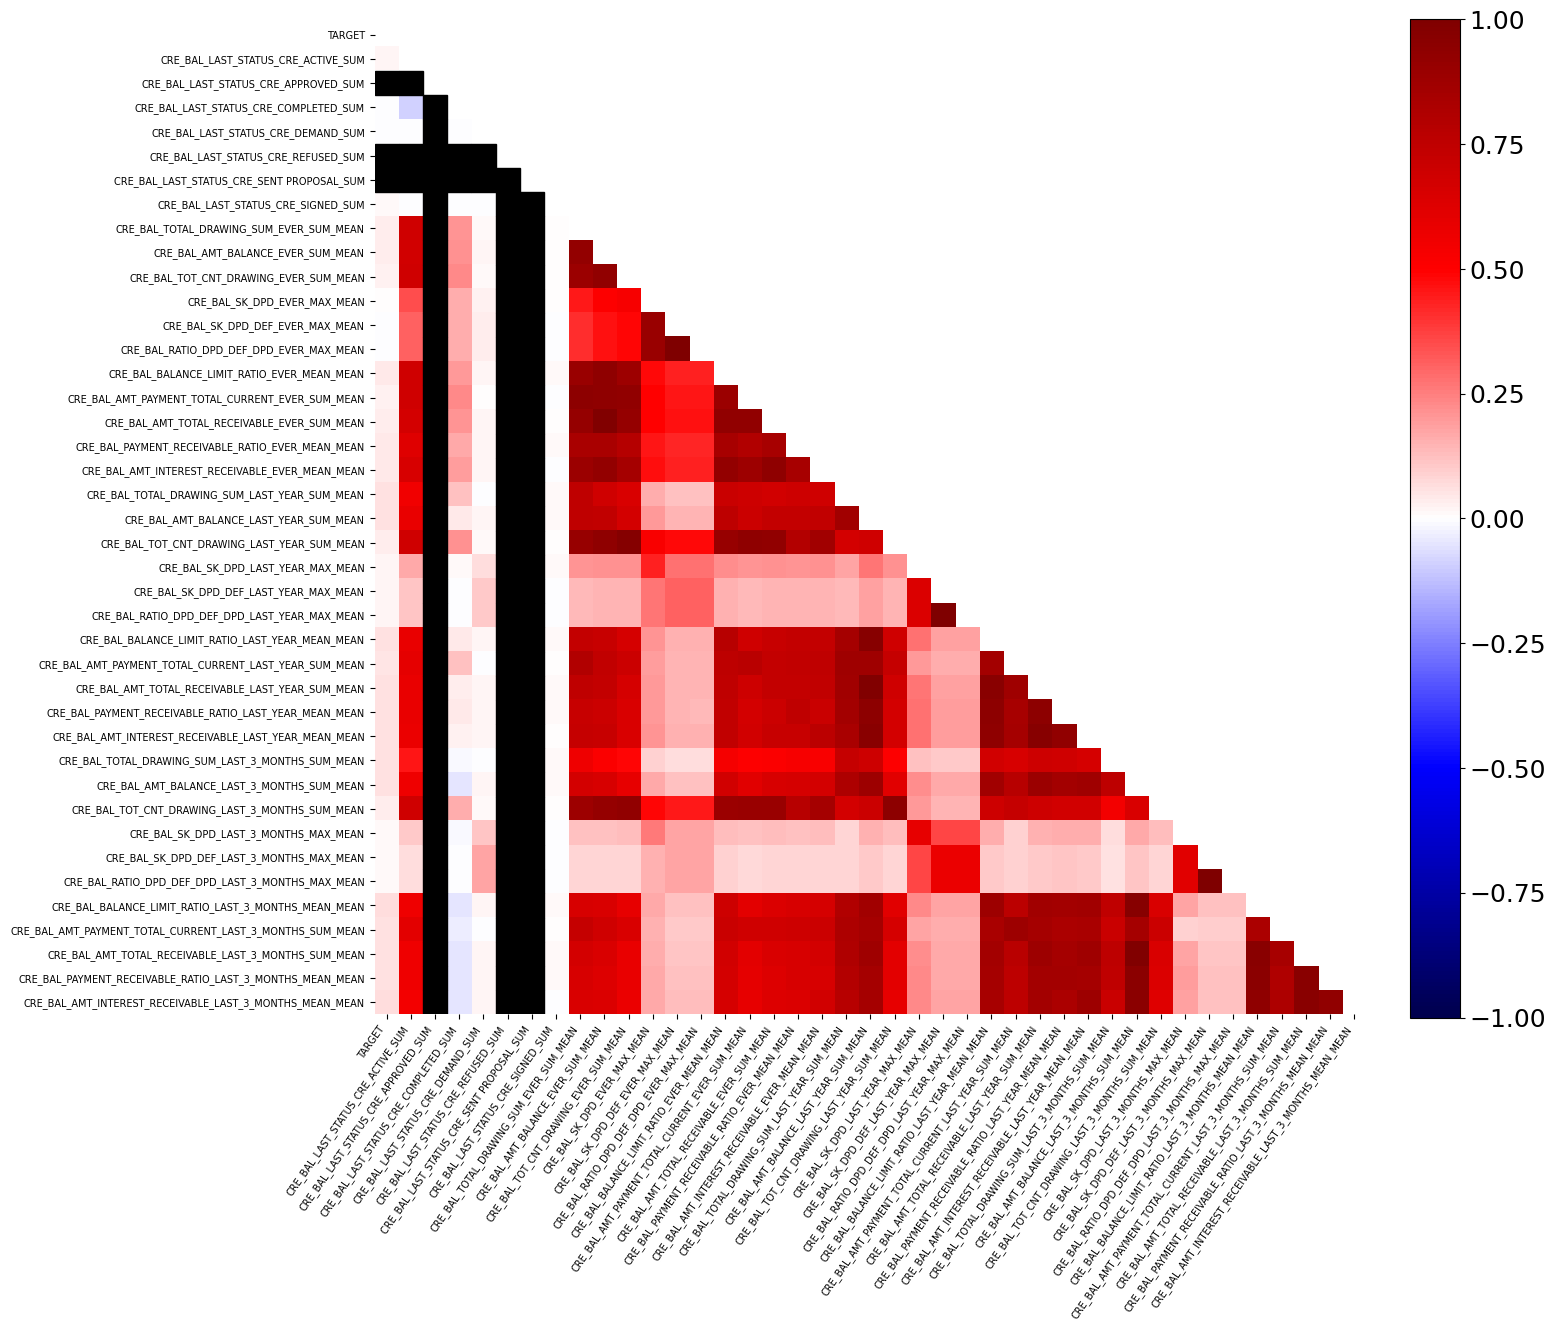

In [15]:
num_corr = credit_and_target.corr(method="kendall")
fig, ax = plt.subplots(figsize=(14, 14))
plot_triangle_corr_matrix(num_corr, ax=ax, ticks_fs=7)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
A few observations should be noted:

* We've computed many features that show a lot of similarities, with some being nearly identical, as indicated by a Kendall correlation coefficient close to 1. We are aware that accumulating such features could slow down our pipeline and potentially lead to overfitting. For now, we will proceed by training our first model with all the features combined, and later, we'll perform feature selection where many of these redundant features may be removed.
* Some features are also shown in black here, it means that no occurence of it was found. They will probably be irrelevant, we'll amost surely remove them later.
* Some of the new features show a slight relationship with the target variable, which is a positive sign for validating our approach. However, it doesn't yet tell us how these features will interact with others during model training.
</div>

## **Summary**

<div style="background-color: #f8d7dA; padding: 10px; border-radius: 5px;">
Here is a summary of our findings and actions:

* During the EDA, we identified some missing values. No strategy was yet found to impute them, but since they were just an infinitesimal fraction of the dataset, this should not matter much.
* We created 40 new features through a two-stage aggregation process. Some of these features are highly correlated with each other, which could pose issues later on (e.g., overfitting, reduced efficiency). Also some features have no variance since no occurence of it was found after the two stages aggregation. However, a few show a small but noticeable correlation with the target variable, making them potentially valuable.
* We developed the functions that will be used to compute these features and merge them with the main dataframe in the final pipeline.
</div>